# Implementation of the SiPM response functions

This repository attempts to implement the SiPM low light response functions
described in [arXiv:1609.01181][sipm_response] in a python library to allow for interfacing with the broader data analysis tools used by HEP. In this
notebook we will mainly break down the mathematical components that go into the
description given in the paper. And these functions are implemented in the
`sipmpdf.functions` module.

[sipm_response]: https://arxiv.org/pdf/1609.01181.pdf


In [1]:
import sipmpdf
import matplotlib.pyplot as plt
import numpy as np
import mplhep
import zfit


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Here we will first define the parameters that enter the `zfit` method, along
with the true value used to generate the pseudo data. The meaning of each term
will be explain along the documentation.

In [2]:
pedestal_t = 5.0
gain_t = 150.0
common_noise_t = 15.0
pixel_noise_t = 2.0
poisson_mean_t = 2.5
poisson_borel_t = 0.05
ap_beta_t = 100
ap_prob_t = 0.05
dc_prob_t = 0.01
dc_res_t = 5e-3
N_Events = 100_000

pedestal = zfit.Parameter('pedestal value', pedestal_t, -10, 50)
gain = zfit.Parameter('gain', gain_t, 100, 200)
common_noise = zfit.Parameter('common_noise', common_noise_t, 5, 25)
pixel_noise = zfit.Parameter('pixel_noise', pixel_noise_t, 1, 3)
poisson_mean = zfit.Parameter('poisson_mean', poisson_mean_t, 2, 3)
poisson_borel = zfit.Parameter('poisson_borel', poisson_borel_t, 0, 0.1)
ap_beta = zfit.Parameter('ap_beta', ap_beta_t, 20, 120)
ap_prob = zfit.Parameter('ap_prob', ap_prob_t, 0.0, 0.2)
dc_prob = zfit.Parameter('dc_prob', dc_prob_t, 0.0, 0.1)
dc_res = zfit.param.ConstantParameter('dc_res', dc_res_t)
obs = zfit.Space('x', limits=(-200, +1500))

## The generalized Poisson distribution

The [Generalized Poisson distribution][gen_poisson] $GP(x;\mu,\lambda)$ is used
to model the probability of a number of primary discharges ($n_{p.e.}$ for
number of photoelectroncs) occur due to an incident light source. The
probability deviation from a simple Poisson distribution due to in-time
correlated discharges driven by optical crosstalk within the SiPM.

$$
GP(k=n_{p.e}; \mu, \lambda) = \frac{\mu(\mu + \lambda x)^{k-1}}{k!}\exp(-(\mu+\lambda x))
$$

This function is implemented as `sipmpdf.functions.generalized_poisson`.

[gen_poisson]: https://www.jstor.org/stable/1267389


Text(0, 0.5, 'Probability')

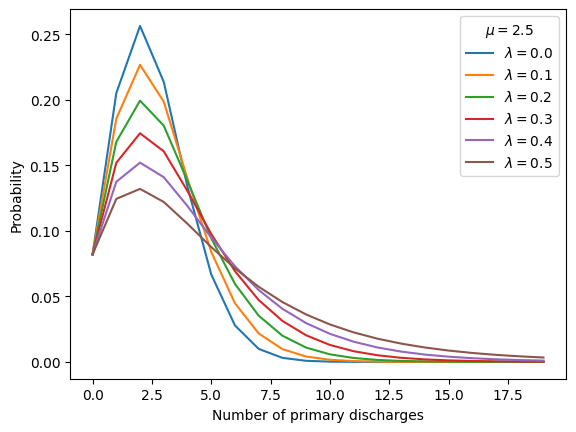

In [3]:
n = np.arange(20)
for idx, borel in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]):
  plt.plot(n,
           sipmpdf.functions.generalized_poisson(n, poisson_mean_t, borel),
           label=f'$\lambda={borel}$')
plt.legend(title=f'$\mu={poisson_mean_t:.1f}$')
plt.xlabel('Number of primary discharges')
plt.ylabel('Probability')

Let us also provide a pseudo number generator for generating integers following
the generalized Poisson distribution, as well as beginning generating the pseudo
data of the expected response of a SiPM. (Using a fixed random number seed to
ensure reproducibility) 

Text(0, 0.5, 'Number of events')

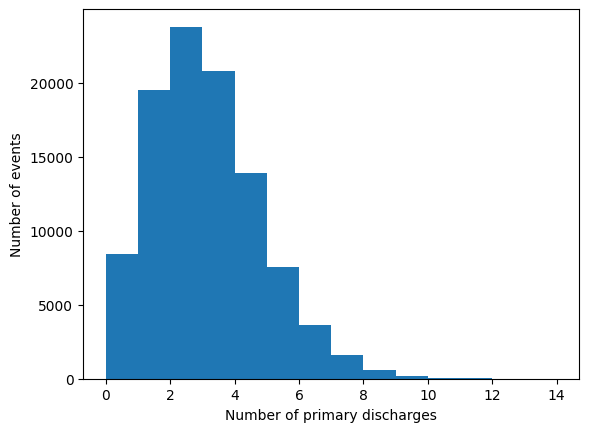

In [4]:
import scipy.stats


class GeneralPoissonRNG(scipy.stats.rv_discrete):
  "Generalized Poisson distribution"
  def _pmf(self, k, mu, lam):
    return sipmpdf.functions.generalized_poisson(k=k, mean=mu, borel=lam)


# Defining the random number generatos with fixed seeds
gen_poisson_rng = GeneralPoissonRNG(seed=123_456_789)
numpy_rng = np.random.default_rng(seed=234_567_890)

# Getting a list of primary discharge counts for future pseudo data generation.
response_npe = gen_poisson_rng.rvs(mu=poisson_mean_t,
                                   lam=poisson_borel_t,
                                   size=N_Events)

plt.hist(response_npe, bins=np.arange(15))
plt.xlabel('Number of primary discharges')
plt.ylabel('Number of events')

## A Gaussian smeared General Poisson distribution

Here let use demonstrate the simplest response model that excludes other
nonlinear effects other than cross talk. Each of the $n_{p.e}$ will be scaled by
the gain factor $g$, and also subject to noise effects. Aside from the common
noise $\sigma_0$, the apparent noise will also be impacted by the $n_{p.e}$, as
there are also per-pixel variation in the system, which we will notate as
$\sigma_p$. Overall, this results the convolution of the General Poisson
distribution smeared by a Gaussian noise. The PDF of this model is given as:

$$
P(x; p, g, \mu, \lambda, \sigma_0, \sigma_1) =
\sum_{n_{p.e}=0}^{\infty} GP(n_{p.e};\mu,\lambda) \cdot
N(x; p + n_{p.e} g, \sigma(n_{p.e}))
$$

Where $GP$ is the general Poisson distribution (shown previously), and $N(x;
m,\sigma)$ is the Gaussian distribution a mean value $m$ and standard deviation
$\sigma$. The value $p$ notates the pedestal shift (constant offset) of the
readout system from the apparent 0 point, and $\sigma(n)$ is used to calculate
the varying noise factor arising from pixel variation noise $\sigma(n) =
\sqrt{\sigma_0^2 + n\sigma_p^2}$. For demonstration let us plot this model that
has already been implemented in the `sipmpdf.functions` module.


Text(30, 0.000630828867285034, '')

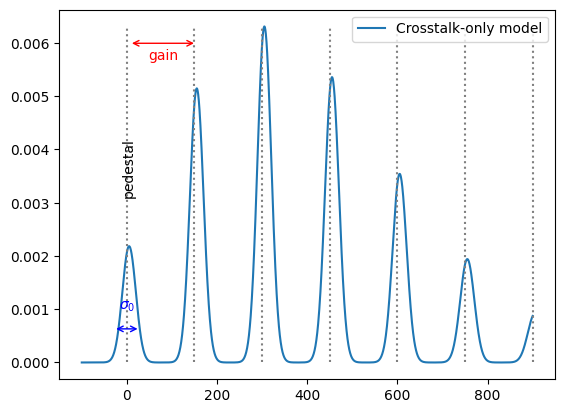

In [5]:
x = np.linspace(-100, 900, 2000)
y = sipmpdf.functions.sipm_response_no_dark_no_ap(x,
                                                  pedestal=pedestal_t,
                                                  gain=gain_t,
                                                  common_noise=common_noise_t,
                                                  pixel_noise=pixel_noise_t,
                                                  poisson_mean=poisson_mean_t,
                                                  poisson_borel=poisson_borel_t)
plt.plot(x, y, label=f'Crosstalk-only model')
ymax = np.max(y)
plt.legend()
plt.vlines(gain_t * np.arange(7),
           ymin=0,
           ymax=np.max(y),
           color='gray',
           linestyles='dotted')
plt.annotate('pedestal', [pedestal_t, ymax * 0.5], rotation=90, ha='center')
plt.annotate('gain', [pedestal_t + gain_t / 2, ymax * 0.9],
             ha='center',
             color='red')
plt.annotate('',
             xy=(pedestal_t, ymax * 0.95),
             xytext=(pedestal_t + gain_t, ymax * 0.95),
             arrowprops=dict(arrowstyle='<->', color='red'))

plt.annotate('$\sigma_0$', [0, 0.001], ha='center', color='blue')
plt.annotate('',
             xy=(-30, ymax * 0.1),
             xytext=(30, ymax * 0.1),
             arrowprops=dict(arrowstyle='<->', color='blue'))


Though this will not be officially supported, the user can implement a simple
z-fit PDF to use this model. We are going to give a stand alone example here, as
the full response function is even more expensive to compute. Notice since the
evaluation of functions is expensive, users should attempt to use a binned fit
where ever possible. Here we first declare the objects required for the fit:

In [6]:
# Simple declaration of the zfit PDF
class DemoSiPMPDF(zfit.pdf.ZPDF):
  _N_OBS = 1
  _PARAMS = [
    'pedestal', 'gain', 'common_noise', 'pixel_noise', 'poisson_mean',
    'poisson_borel'
  ]

  def _unnormalized_pdf(self, x):
    x = zfit.z.unstack_x(x)
    return sipmpdf.functions.sipm_response_no_dark_no_ap(
      x, **{k: self.params[k]
            for k in self._PARAMS})

# Declaring the "unbinned" PDF
pdf = DemoSiPMPDF(obs=obs,
                  pedestal=pedestal,
                  gain=gain,
                  common_noise=common_noise,
                  pixel_noise=pixel_noise,
                  poisson_mean=poisson_mean,
                  poisson_borel=poisson_borel)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1800, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)


We can further modify the response to properly model gain and noise effects from
the raw integer discharge count array.


Text(0, 0.5, 'Number of events')

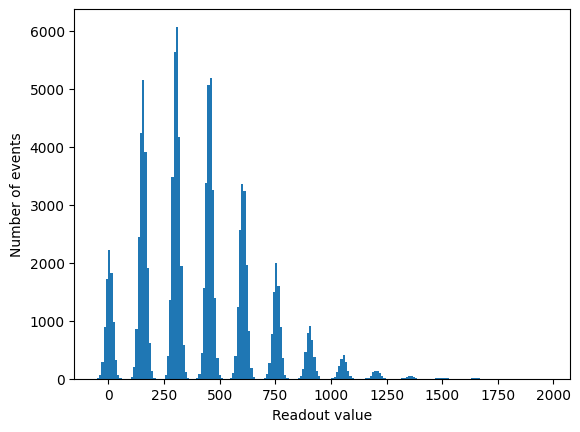

In [7]:
# For each discharge count, the noise scale is different. is a set random uncertainty
gauss_noise = np.sqrt(common_noise_t**2 + response_npe * pixel_noise_t**2)
response_with_gauss_noise = numpy_rng.normal(
  loc=pedestal_t + response_npe * gain_t, scale=gauss_noise)

plt.hist(response_with_gauss_noise, bins=200)
plt.xlabel('Readout value')
plt.ylabel('Number of events')

Then we can convert the generated pseudo data into the data format required by
`zfit`. (We will be using binned fits to speed up calculation time), and run the
minimizer to get the results. 

In [8]:
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response_with_gauss_noise)
data_bin = data_unbinned.to_binned(obs_bin)

nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fa99c0b4dc0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fa9841efd90>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00063 │ 894.8057    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value               4.985  +/-   0.089       False
gain                       149.982  +/-   0.029       False
common_noise               14.9967  +/-   0.064       False
pixel_noise                1.99261  +/-    0.16       False
poisson_mean               2.49728  +/-  0.0075       False
poi

As a sanity check, let use plot the fit results:

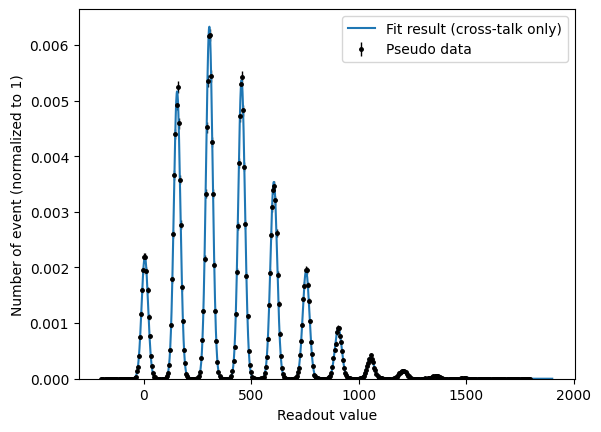

In [9]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (cross-talk only)')
plt.xlabel('Readout value')
plt.ylabel('Number of event (normalized to 1)')
plt.legend()


## Afterpulse response

For $k$ pixels undergoing primary discharges, each discharged pixel has a
probability $P_{a.p}$ of undergoing afterpulsing. The contribution of
afterpulsing to the readout is modeled using a simple exponential model
extending above the primary discharge, with the afterpulse factor $\beta$:

$$A_{a.p.}(x;n_{a,p}=1,\beta)=\frac{1}{\beta}\exp\left(-\frac{x}{\beta}\right); \quad (x>0)$$

Note: The [source paper](https://arxiv.org/pdf/1609.01181.pdf) for these
equations uses $i$ in place of $n_{a.p.}$. We used the second option for
improved readability

Here $x$ is the additional contribution of the afterpulse above the primary
discharge. Contributions from multiple afterpulses can also be modelled by the
analytic convolution of the multiple exponential distributions:

$$
A_{a.p.}(x;n_{a.p.},\beta)
=\otimes_1^{n_{a.p.}}A_{a.p.}(x;n_{a.p.}=1,\beta)
=\frac{x^{(n_{a.p.}-1)}}{(n_{a.p.}-1)!\beta^{n_{a.p.}}}\exp\left(-\frac{x}{\beta}\right); \quad (x>0)
$$

While the total contribution of the primary discharge and the variable
afterpulsing should be subject to noise and gain variations in the system,
$A(x; n_{a.p.},\beta,\sigma)$, the convolution of the exponential distribution
with a normal distribution, does not have a simple analytic form. Instead, for
multiple afterpulse contributions, we work under the assumption that the
exponential factor $\beta$ of the afterpulse is generally larger than the noise
factor $\sigma_0$. For number of afterpulses $n_{a.p.}>1$ the afterpulse
contribution distribution is sufficiently smooth such that additional
convolution with the noise factor is not needed i.e.
$A(x;n_{a.p.}>1,\beta,\sigma)\sim A(x;n_{a.p.}>1,\beta)$.

For $n_{a.p.}=1$, we use the approximation:

$$
A_{a.p.}(x;n_{a.p.}=1,\beta,\sigma)
= A_{a.p.}(x;n_{a.p.}=1,\beta) \otimes G(x;\sigma)
\sim \frac{1}{2\beta} \exp\left(-\frac{x}{\beta}\right)\left(1+\mathrm{erf}\left(\frac{x}{\sigma_k \sqrt{2}}
\right)\right)
$$

The following plot is an example of afterpulsing contributions with various
values of $n_{a.p.}$.


/home/ensc/VirtualENV/sipmenv/lib/python3.8/site-packages/sipmpdf/functions.py:211: RuntimeWarning: invalid value encountered in log
  kern.log(kern.power(x, n_ap - 1)) - kern.log(kern.power(beta, n_ap)) -


Text(0, 0.5, 'Number of Events (Normalized to 1)')

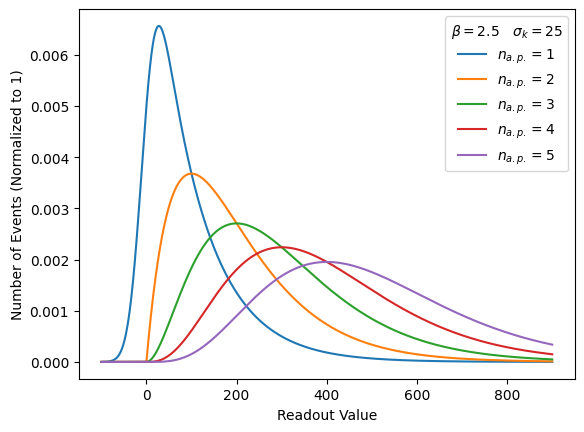

In [10]:
x = np.linspace(-100, 900, 2000)

for n_ap in np.arange(1, 6):
  y = sipmpdf.functions.ap_response_smeared(x=x, smear=25, n_ap=n_ap, beta=100)
  plt.plot(x, y, label=r'$n_{a.p.}=' + str(n_ap) + '$')

plt.legend(title=r'$\beta=2.5\quad\sigma_k=25$')
plt.xlabel('Readout Value')
plt.ylabel('Number of Events (Normalized to 1)')


The impact of afterpulsing on the readout spectrum is that the primary discharge
peak has additional non-Gaussian smearing from probabilistic contributions from
afterpulsing. The degree by which this smearing occurs also depends on the
number of primary discharges that occur, as that also determines the number of
afterpulses that can occur. The function form of this smearing can be
analytically expressed using the Binomial probability of $n_{a.p.}$ occuring
given $k$ primary discharges $B(n_{a.p.};k,P_{a.p.})$.

$$B(0;k,P_{a.p.})G(x-kg,\sigma(k))+\sum_{n_{a.p.}=1}^k B(n_{a.p.};k,P_{a.p.})A(x-kg;n_{a.p.},\beta,\sigma(k))$$

An example of different degrees of non-Gaussian smearing caused by afterpulsing
for different numbers of primary discharges is shown below. Here we are
intentionally fixing $\sigma(k)=10$ for all peaks so that we can see the effects
of the non-Gaussian smearing caused by afterpulse response changing the response
shape, even if per-pixel noise is fixed at 0.


Text(0.5, 1.0, 'Total Afterpulse Response for Fixed Number of Photoelectrons')

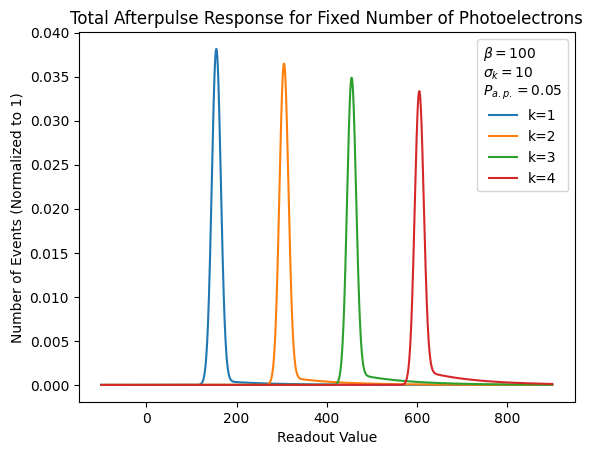

In [11]:
x = np.linspace(-100, 900, 2000)

for k in np.arange(1, 5):
  y = sipmpdf.functions._full_afterpulse_response(x=x,
                                                  ap_beta=ap_beta_t,
                                                  ap_prob=ap_prob_t,
                                                  total=k,
                                                  pedestal=pedestal_t,
                                                  gain=gain_t,
                                                  sigma_k=10)
  plt.plot(x, y, label=f'k={k}')
plt.legend(title='\n'.join([
  r'$\beta=' + str(ap_beta_t) + '$',  #
  r'$\sigma_k=10$',  #
  r'$P_{a.p.}=' + str(ap_prob_t) + '$',
]),
           loc='upper right')
plt.xlabel('Readout Value')
plt.ylabel('Number of Events (Normalized to 1)')
plt.title('Total Afterpulse Response for Fixed Number of Photoelectrons')

Putting this together with the General Poisson distribution for the number of
the primary discharges that can occur, we arrive at another semi-realistic
response model.

$$
GP(0;\mu,\lambda)G(x;p,\sigma_0) +
\sum_{k=1}GP(k;\mu,\lambda) \left(
    B(0;k,P_{a.p.})G(x;p+kg,\sigma_k)
    +\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)\right
)
$$

The cut of at $n_{a.p}=10$ is expected since the afterpulsing response is to
help reduce the number of calculations, since $P_{a.p}$ is expected to be small,
and $k$ is also expected to be small.

This function is implemented as `sipmpdf.functions.sipm_response_no_dark`, and
provided as at `sipm.pdf` modules as the `SiPMResponse_NoDC_PDF`


We can further modify the SiPM response by generating dark current responses
from an exponential distribution. For each event, we can generate up to 100
after pulse responses, and then discard responses where the afterpulse response
count exceeds the primary discharge count, and also randomly discard afterpulse
responses to emulate the binomial process.

Text(0, 0.5, 'Number of events')

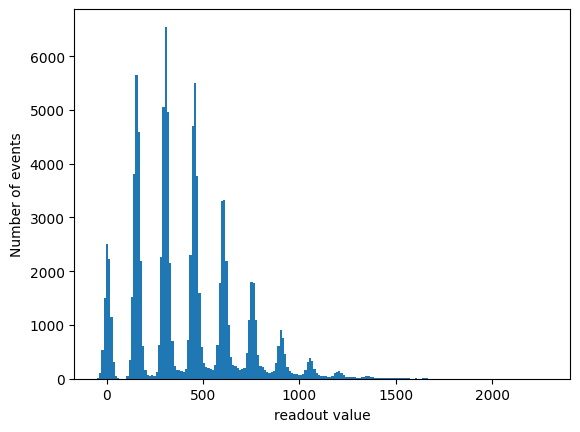

In [12]:
ap_shape = (N_Events, 10)
# Getting random exponential distribution.
response_ap = numpy_rng.exponential(ap_beta_t, size=ap_shape)
# Discarding AP responses if number of AP exceeds number of primary discharges
response_ap = np.where(
  np.indices(ap_shape)[1] < response_npe[:, np.newaxis], response_ap, 0)
# AP only has finite chance of appearing
response_ap = np.where(
  numpy_rng.random(size=ap_shape) > ap_prob_t, 0, response_ap)

# For each event, we only see sum of ap responses
response_ap = np.sum(response_ap, axis=-1)

# Constructing the response with no random smearing
response_with_ap = numpy_rng.normal(
  loc=pedestal_t + response_npe * gain_t + response_ap, scale=gauss_noise)

plt.hist(response_with_ap, bins=200)
plt.xlabel('readout value')
plt.ylabel('Number of events')


Next let us attempt to fit the psuedo data to the model function. This PDF is
already provided in the `sipmpdf.pdf` module as `SiPMResponse_NoDC_PDF`. We will
be running the same binned fitting routine as with the example PDF previously.


In [13]:
#Create pdf for the response with no dark current
pdf = sipmpdf.pdf.SiPMResponse_NoDC_PDF(obs=obs,
                                        pedestal=pedestal,
                                        gain=gain,
                                        ap_beta=ap_beta,
                                        ap_prob=ap_prob,
                                        common_noise=common_noise,
                                        pixel_noise=pixel_noise,
                                        poisson_mean=poisson_mean,
                                        poisson_borel=poisson_borel)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response_with_ap)
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fa96423c220>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fa96445d9a0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00036 │ 1228.49     │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value             5.08153  +/-   0.099       False
gain                       149.949  +/-   0.037       False
common_noise               15.0383  +/-   0.076       False
pixel_noise                1.57016  +/-     0.3       False
poisson_mean               2.49556  +/-  0.0077       False
poi

And comparing the pseudo data distribution with the fit result for a sanity
check.

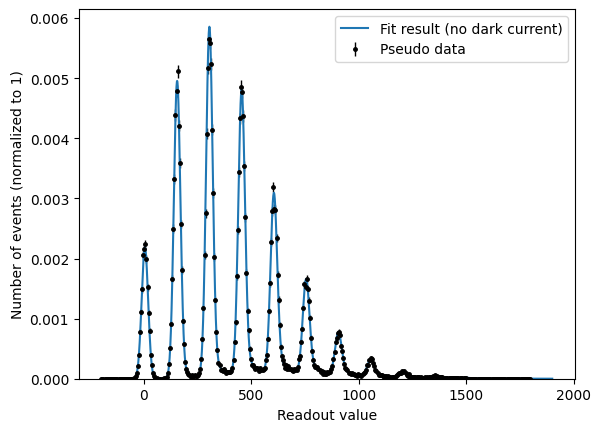

In [14]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result (no dark current)')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()

## Dark Current Response
Dark current is temporarily uncorrelated discharges wandering into the data
collection window. The model of this is evaluated in the paper as: 

$$ 
D(x)=\frac{1}{2 \log(\frac{g}{\epsilon})}\left(\frac{1}{x-p}+\frac{1}{p+g-x} \right)\;;\quad 
(p+\epsilon g<x < p + (1-\epsilon) g)
$$

Where $\epsilon$ is the resolution factor of the data collection relative to the
discharge peak shape. A numerical convolution of this function with a normal
distribution with be implemented in the model to account for electrical noise.
(Given the sharp features of $D(x)$, the limitations of numerical convolution
are why the function appears "noisy")

Text(0, 0.5, 'Number of events (normalized to 1)')

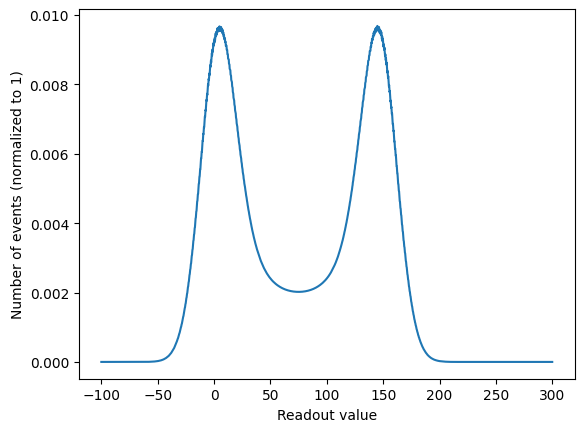

In [15]:
x = np.linspace(-100, 300, 2000)
dc = sipmpdf.functions.darkcurrent_response_smeared(x=x,
                                                    smear=common_noise_t,
                                                    gain=gain_t,
                                                    resolution=10e-4)

plt.plot(x, dc, label="Dark Current Response Smeared")
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')

Adding dark current contributions to events where there were no time-correlated
discharges, we arrive at the full model of the SiPM Response:

$$
GP(0;\mu,\lambda) \left(
   (1-P_{d.c.})G(x;p,\sigma_0)+P_{d.c.}D(x)
\right) +
\sum_{k=1}GP(k;\mu,\lambda) \left(
  B(0;k,P_{a.p.}) G(x;p+kg,\sigma_k)
  +\sum_{n_{a.p.}=1}^{10} B(n_{a.p.};k,P_{a.p.})A(x;n_{a.p.},k,\beta)
\right)
$$

This function is implemented as `sipmpdf.functions.sipm_response` and the
corresponding PDF object is provided as `sipmpdf.pdf.SiPMResponsePDF`.


Again, we can modify the SiPM response pseudo data. The dark current model given
above is explored in the paper by assuming the primary discharge can be modelled
in time as a capacitative discharge (an exponential function in time), dark
current can then be modelled by a random integration window. Notice that the
resolution factor of $5\times10^{-3}$ corresponds to an integration window
$\sim5$ times wider than the discharge time scale (which we fix at 1).

Text(0, 0.5, 'Number of events')

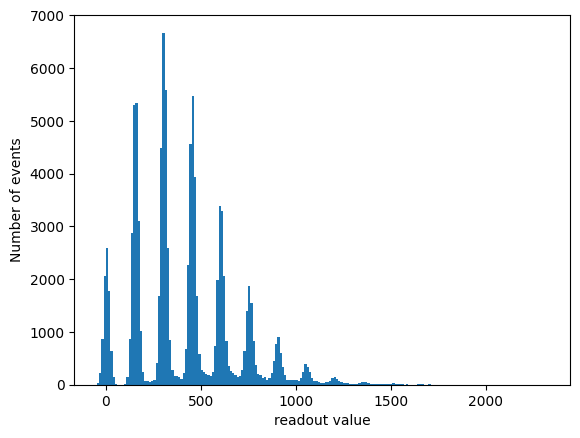

In [16]:
tint = 5
# Getting random integration window starting time.
t = numpy_rng.uniform(-tint, tint, size=N_Events)

# Getting integration response
response_dc = np.where(t < 0,
                       np.exp(t) * (1 - np.exp(-tint)),  #
                       1 - np.exp((-tint - t))) * gain

# Dark current primarily contributes to npe=0 events.
response_dc = np.where(response_npe == 0, response_dc, 0)
# Dark current only has finite chance of appearing
response_dc = np.where(
  numpy_rng.random(size=N_Events) < dc_prob_t, response_dc, 0)

# Constructing the noiseless response
response = pedestal_t + response_npe * gain_t + response_ap + response_dc

# Injecting random noise into all responses
response = numpy_rng.normal(loc=response, scale=gauss_noise)

plt.hist(response, bins=200)
plt.xlabel('readout value')
plt.ylabel('Number of events')


Now we can again running the fitting results.

In [17]:
#Create pdf for the full response
pdf = sipmpdf.pdf.SiPMResponsePDF(obs=obs,
                                  pedestal=pedestal,
                                  gain=gain,
                                  ap_beta=ap_beta,
                                  ap_prob=ap_prob,
                                  common_noise=common_noise,
                                  pixel_noise=pixel_noise,
                                  poisson_mean=poisson_mean,
                                  poisson_borel=poisson_borel,
                                  dc_prob=dc_prob,
                                  dc_res=dc_res)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=response)
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fa93a31cdc0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fa96423c6d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00043 │ 1208.77     │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value             4.99696  +/-   0.099       False
gain                       149.968  +/-   0.038       False
common_noise               14.8542  +/-   0.076       False
pixel_noise                2.31825  +/-     0.2       False
poisson_mean               2.49762  +/-  0.0077       False
poi

As well as plotting the results with the psuedo data for a final sanity check.

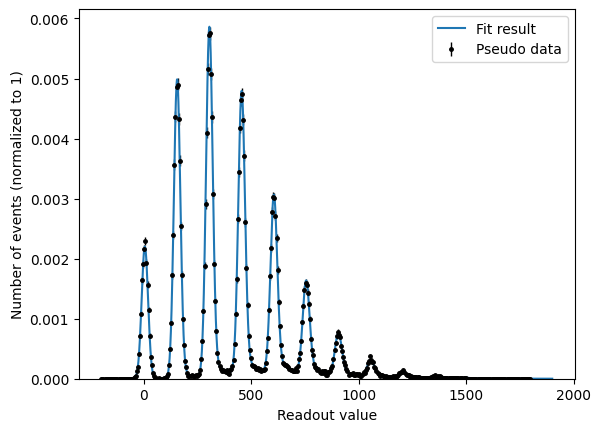

In [18]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))

ax = mplhep.histplot(h,
                     density=True,
                     label='Pseudo data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)
plt.plot(x, y, label='Fit result')
plt.xlabel('Readout value')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()